<a href="https://colab.research.google.com/github/stef1927/dl-samples/blob/master/numpy-nn/numpy_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A feed forward neural network implemented only with numpy

In this notebook, a feed forward neural network is implemented only using numpy and it is used to predict daily bike rentals using the bike sharing dataset from
Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", published in Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

The original version of this notebook can be found [here](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-bikesharing/Predicting_bike_sharing_data.ipynb).




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

This steps requires manually uploading the datasets from the GH repository bike-sharing-dataset directory into a directory under the content directory, using the Files icon on the left.

In [2]:
data_path = 'bike-sharing-dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Analysing the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. 

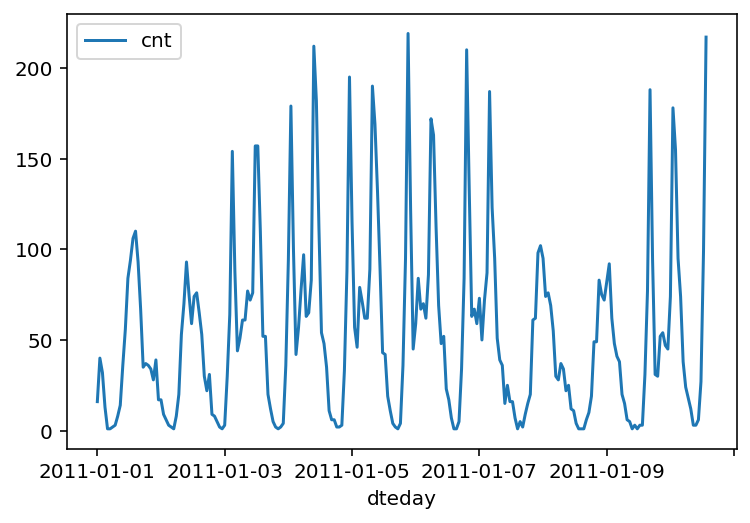

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Categorical variables
The categorical variables like season, weather and month need to be converted into binary variables, and this is done with Pandas `get_dummies()`.

In [5]:
categorical_variables = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in categorical_variables:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Scaling quantitative variables
Quantitative values are scaled using the mean and standard deviation to make
training the network easier. 

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'

quantitative_variables = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}
for each in quantitative_variables:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Splitting the data into training, testing, and validation sets

The data for the last approximately 21 days will be used as a test set after the network has been trained.

In [22]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

The data is split into two sets, one for training and one for validating as the network is being trained. Since this is time series data, the network will train on historical data, then try to predict on future data (the validation set).

In [27]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## The network

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. 
  

In [16]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        """ Save the parameters passed in, and initialize the weights and activation function """
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = learning_rate
        
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes ** -0.5,
                                                        (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes ** -0.5,
                                                         (self.hidden_nodes, self.output_nodes))
        

        # This is the sigmoid activation function
        self.activation_function = lambda x: 1 / (1 + np.exp(-x))

    def train(self, features, targets):
        """ Train the network on batch of features and targets:   
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values

            For each record, perform the forward pass and backprop, then update
            the weights when the entire batch has been processed.
        """
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)

        for X, y in zip(features, targets):
            final_outputs, hidden_outputs = self.forward_pass_train(X)
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y,
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)

    def forward_pass_train(self, X):
        """Implement the forward pass """
       
        hidden_outputs = self.activation_function(np.dot(X, self.weights_input_to_hidden))  
        final_outputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        return final_outputs, hidden_outputs


    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        """ Implement backpropagation:

            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
        """
       
        error = y - final_outputs 
        hidden_error = np.dot(error, self.weights_hidden_to_output.T)
        output_error_term = error * 1
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

        delta_weights_i_h += hidden_error_term * X[:, None]
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        """ Update weights on gradient descent step:

            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records
        """
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records

    def run(self, features):
        """ Run a forward pass through the network with input features"""
        hidden_outputs = self.activation_function(np.dot(features, self.weights_input_to_hidden)) 
        return np.dot(hidden_outputs, self.weights_hidden_to_output)

In [17]:
def MSE(y, Y):
  """Calculate the Meand Squared Error"""
  return np.mean((y-Y)**2)

## Unit tests

Some unit tests to check the correctness of the network implementation. 

In [18]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.014s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training

The network is trained for a number of iterations after choosing the hyper parameters (learning rate and network shape). The train and validation losses
are calculated and stored so that they can be plotted later on.

In [28]:
import sys

###################
# Hyperparameters
###################
iterations = 3000
learning_rate = .75
hidden_nodes = 18
output_nodes = 1


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.070 ... Validation loss: 0.140

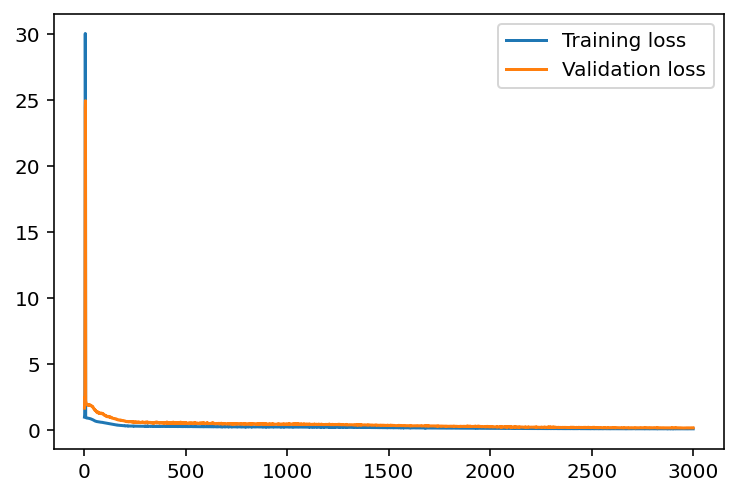

In [29]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check the predictions

Use the test data to view how well the network is modeling the data. 

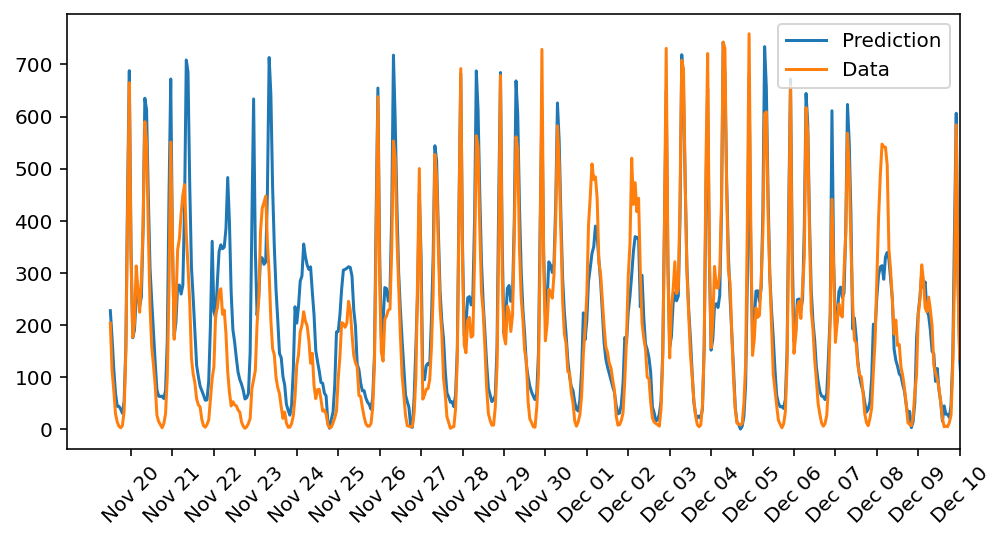

In [30]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)